## Forecasting Hourly Energy Consumption using XGBoost

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

## Load dataset

In [2]:
data = pd.read_csv('./PJME_hourly.csv', index_col=[0], parse_dates=[0])

## Exploratory Data Analysis

In [3]:
data.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [4]:
data = data.rename(columns = {'PJME_MW' :'MW'})

In [5]:
data.head()

,MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


## Stationarity test

In [6]:
result = adfuller(data)
print(f'p value : {result[1]}')

p value : 2.0221245081527322e-30


<Axes: title={'center': 'Hourly data consumption'}, xlabel='Datetime'>

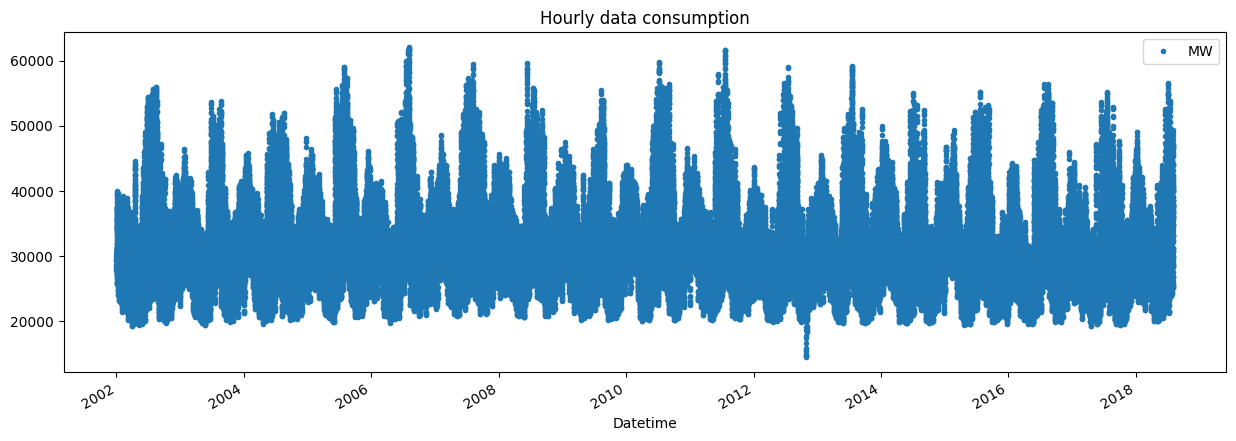

In [7]:
data.plot(style='.', figsize=(15,5), title='Hourly data consumption')

<Axes: ylabel='Frequency'>

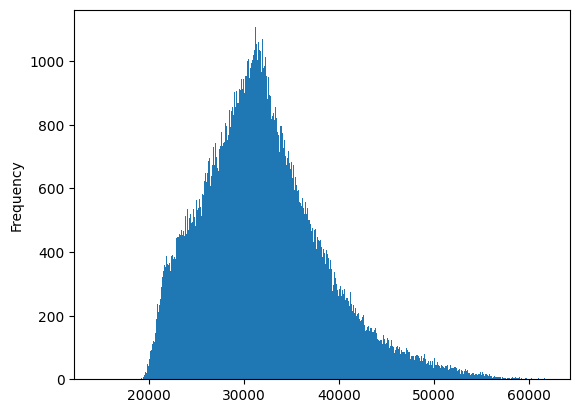

In [8]:
data['MW'].plot(kind='hist', bins=500)

<Axes: title={'center': 'Outliers'}, xlabel='Datetime'>

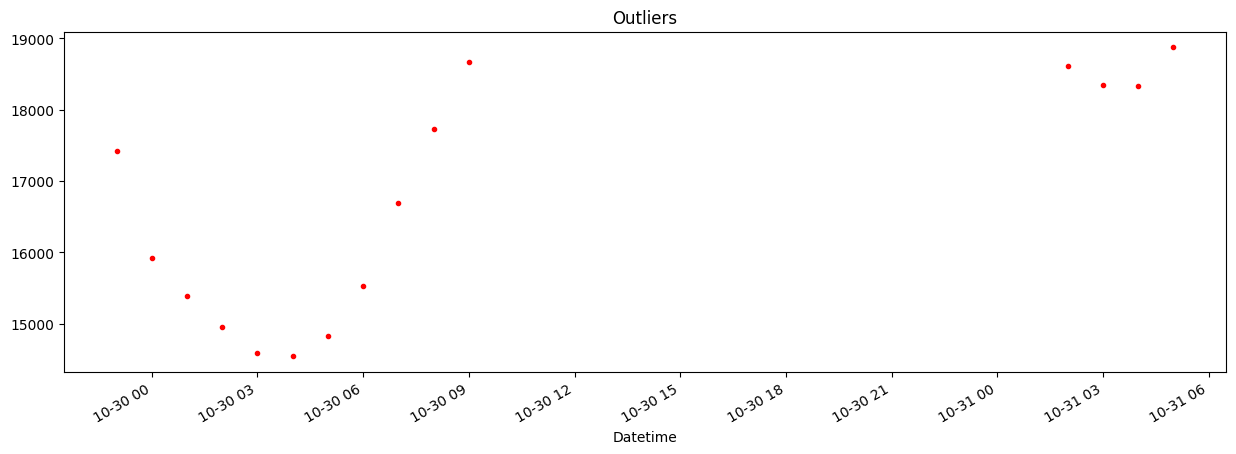

In [9]:
data.query('MW < 19000')['MW'] \
    .plot(style='.',
          figsize=(15, 5),
          color='red',
          title='Outliers')

In [10]:
data = data.query('MW > 19000').copy()


<Axes: xlabel='Datetime'>

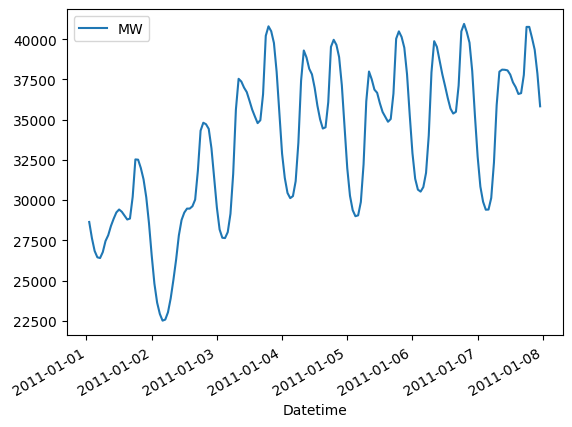

In [11]:
# Weekly analysis

data.loc[(data.index > '01-01-2011') & (data.index < '01-08-2011')].plot()


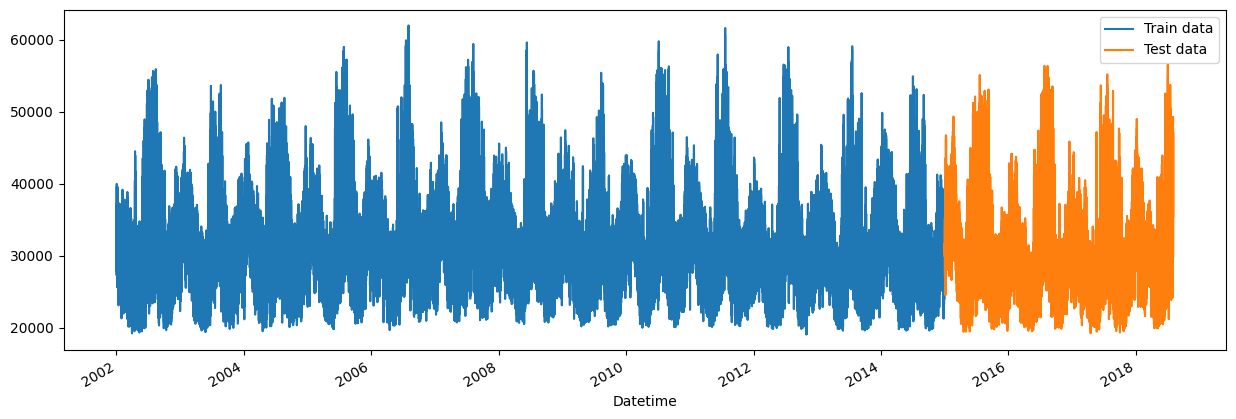

In [12]:
# Split data into train test
split_date = '01-Jan-2015'

train_data = data.loc[data.index <= split_date].copy()
test_data = data.loc[data.index > split_date].copy()


# train test plot 
fig, ax = plt.subplots(figsize=(15,5))
train_data.plot(ax= ax, label = 'Training')
test_data.plot(ax=ax, label = 'Test')
ax.legend(['Train data', 'Test data'])
plt.show()

In [13]:
def create_features(df, label=None):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    return df

In [14]:
data = create_features(data, label='MW')

In [15]:
data.head()

,MW,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,,
2002-12-31 01:00:00,26498.0,2002-12-31 01:00:00,1,1,4,12,2002,365,31,1
2002-12-31 02:00:00,25147.0,2002-12-31 02:00:00,2,1,4,12,2002,365,31,1
2002-12-31 03:00:00,24574.0,2002-12-31 03:00:00,3,1,4,12,2002,365,31,1
2002-12-31 04:00:00,24393.0,2002-12-31 04:00:00,4,1,4,12,2002,365,31,1
2002-12-31 05:00:00,24860.0,2002-12-31 05:00:00,5,1,4,12,2002,365,31,1


<Axes: xlabel='hour', ylabel='MW'>

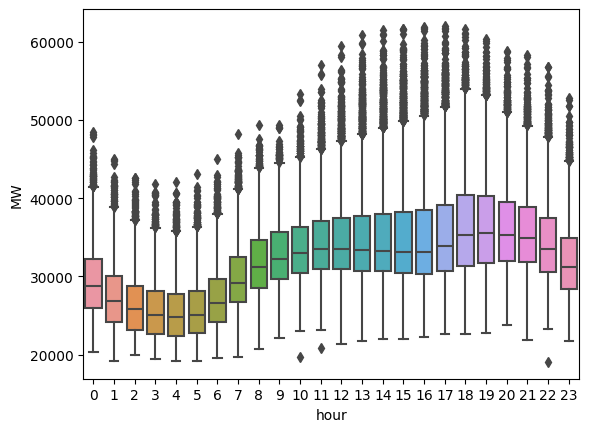

In [16]:
sns.boxplot(data = data, x='hour', y='MW')

<Axes: xlabel='month', ylabel='MW'>

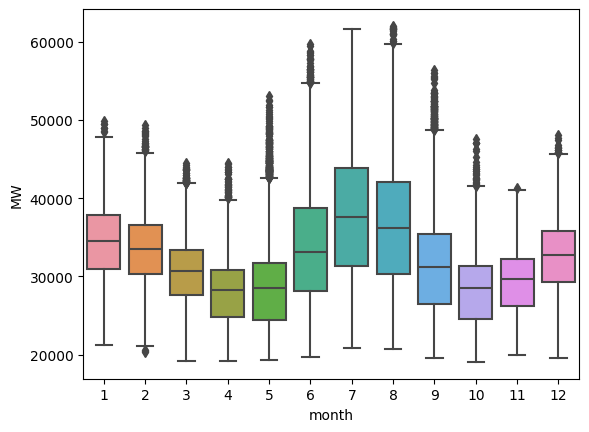

In [17]:
sns.boxplot(data = data, x='month', y='MW')

In [18]:
train_data = create_features(train_data, label='MW')
test_data = create_features(test_data, label='MW')

In [19]:
X_train = train_data[['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear']]
y_train = train_data['MW']


X_test = test_data[['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear']]
y_test = test_data['MW']


## Create XGBoost Model

In [31]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds = 50, learning_rate = 0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=100)

[0]	validation_0-rmse:6405.22478	validation_1-rmse:6480.32111
[100]	validation_0-rmse:3909.56139	validation_1-rmse:4317.04634
[200]	validation_0-rmse:3240.07119	validation_1-rmse:3868.43558
[300]	validation_0-rmse:2984.32672	validation_1-rmse:3756.35181
[400]	validation_0-rmse:2822.65502	validation_1-rmse:3742.57616
[434]	validation_0-rmse:2765.96140	validation_1-rmse:3755.18507


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Feature Importance


<Axes: title={'center': 'Feature importance'}>

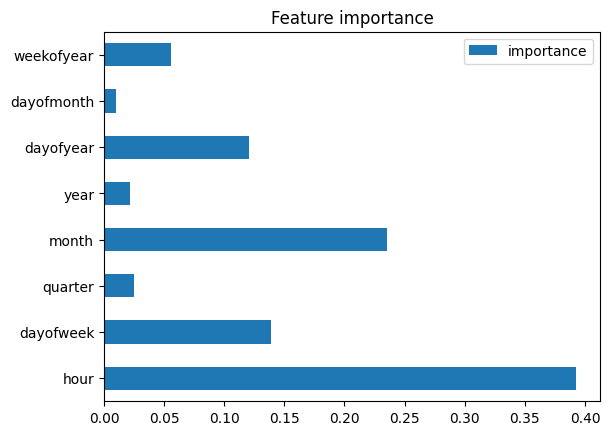

In [21]:
feature_imp = pd.DataFrame(data = reg.feature_importances_, index = reg.feature_names_in_, columns=['importance']) 
feature_imp.plot(kind = 'barh', title= 'Feature importance')

In [22]:
predictions = reg.predict(X_test)

In [23]:
# Calculate MAE
mae = mean_absolute_error(y_test, predictions)

# Calculate MSE
mse = mean_squared_error(y_test, predictions)

# Calculate RMSE
rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE):", mae)

print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 2895.858237193951
Root Mean Squared Error (RMSE): 3737.831474876713


## Forecasting and analysis

In [24]:
test_data['predicted'] = predictions
data = data.merge(test_data[['predicted']], how='left', left_index = True, right_index=True)

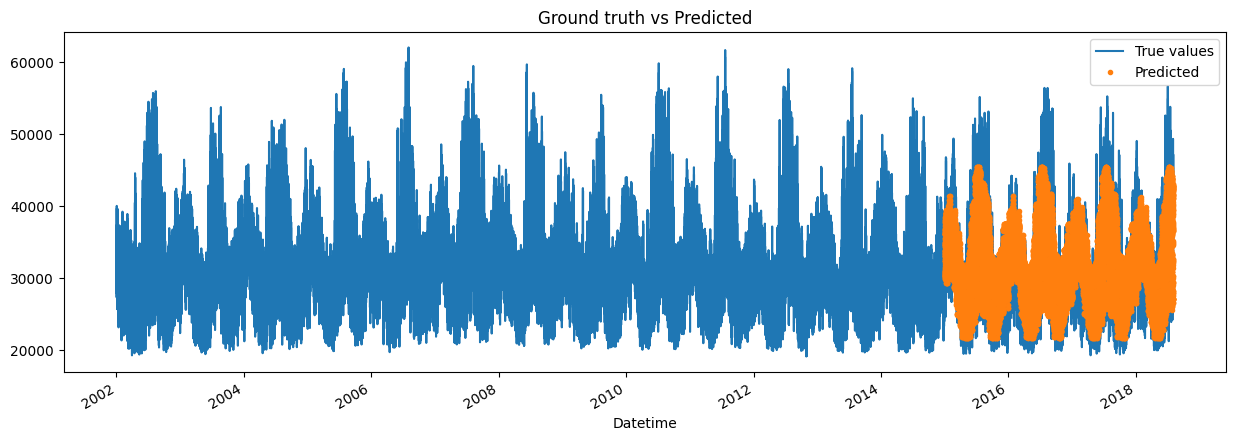

In [25]:
ax = data[['MW']].plot(figsize=(15,5))
data['predicted'].plot(ax=ax, style='.')
plt.legend(['True values', 'Predicted'])
ax.set_title('Ground truth vs Predicted')
plt.show()

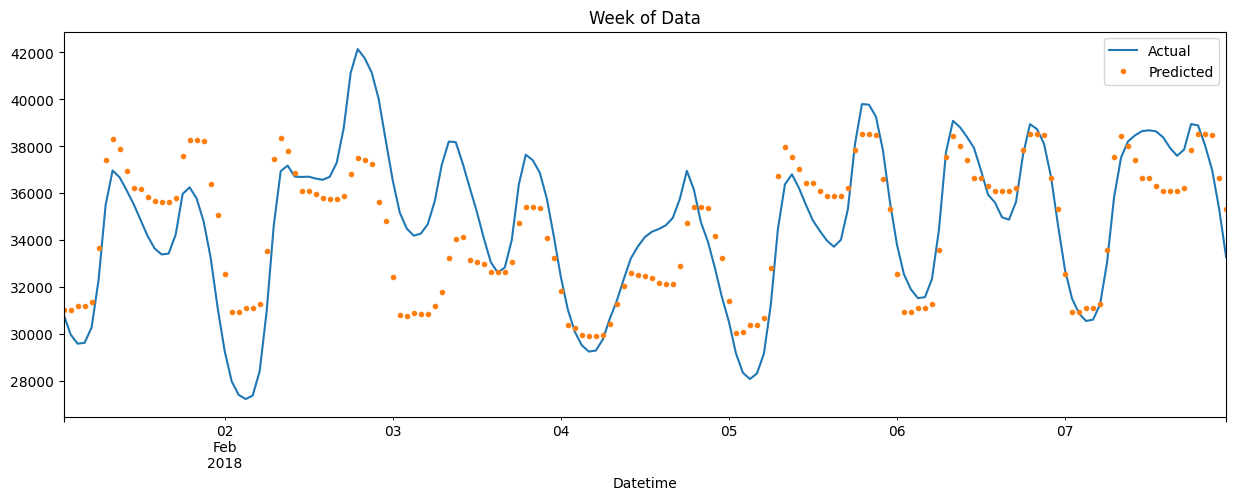

In [26]:
# lets plot for one week

ax = data.loc[(data.index>'02-01-2018') & (data.index < '02-08-2018')]['MW'].plot(figsize=(15,5), title = "Week of Data")
data.loc[(data.index > '02-01-2018') & (data.index < '02-08-2018')]['predicted'].plot(style='.')
plt.legend(['Actual', 'Predicted'])
plt.show()